# Minimum Variance Portfolio, sample cov using MLE linear shrinkage

Shrinkage algorithm implemented from 
    Ledoit, O., and M. Wolf, 2003, “Honey, I Shrunk the Sample Covariance Matrix,” Working
    Paper, Department of Economics and Business, Universitat Pompeu Fabra.
Access: https://ssrn.com/abstract=433840

The performance of the shrinkage estimator is measured in MSE terms of the covariance matrix estimate, using the matrix Frobenius norm

$ ||\hat{\Sigma}-\Sigma||_F = \sqrt{\sum_{i,j} (\hat{\sigma}^2_{ij} - \sigma^2_{ij})^2 }$.
 That is, the squared residual of the element-wise covariances.
 
While the shrinkage estimator is a biased estimator, it can archive a lower MSE than the unbiased sample covariance by having a lower variance.

## Define benchmark returns statistics

ALIV SS     7.726122e+06
NDA SS      7.756970e+06
NHY NO      1.672482e+06
OTE1V FH    6.495656e+06
OUT1V FH    6.518029e+06
SAMPO FH    8.084146e+06
SAND SS     7.219577e+06
SEBA SS     4.946962e+06
TRELB SS    5.876094e+06
YAR NO      6.269732e+06
dtype: float64
[0.29624964 0.28044585 0.29756731 0.99994399 0.99569521 1.        ]
['sample', 'honey', 'MP', 'SKL_LW', 'RIE']
[0.44953597 0.41457958 0.42955221 0.41626322 0.41165666 0.        ]


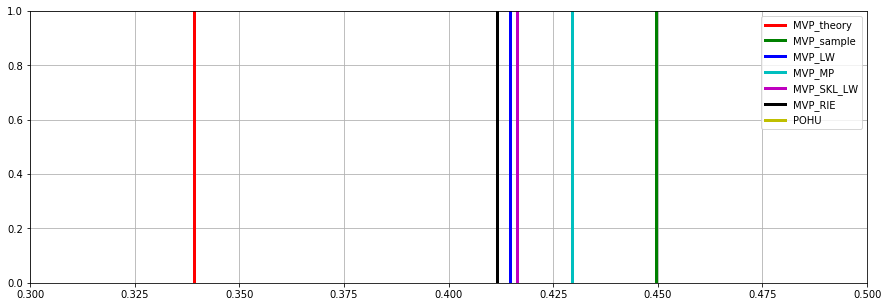

In [85]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import scipy.stats as stats
import pandas as pd
from operator import add
from matplotlib import pyplot as plt
import honey_shrink as hs
import marchenko_pastur as mp
from sklearn.covariance import LedoitWolf


from src.estimation.cov_cleaning import mp_denoise, RIE

import example_data as data



def mvh(idx_r, idx_h, pos, cov):
    idx_sub = np.concatenate([idx_r, idx_h])
    hrhh = cov[idx_h][:,idx_sub]
    hh = cov[idx_h][:, idx_h]
    hdg_h = -np.linalg.inv(hh) @ hrhh @ pos[idx_sub]
    hdg = np.concatenate((np.zeros(len(idx_r)), hdg_h))
    psi = np.zeros(cov.shape[0])
    psi[idx_sub] = hdg
    return psi

#def var(book, cov):
#    return book.pos @ cov.loc[book.pos.index, book.pos.index] @ book.pos

def var(w, cov):
    return w @ cov @ w
    
# =========================
# ======= Load Data =======
# =========================
lvl_df, book = data.get_example_data()
#book._pos = book.pos[['NDA SS']]
print(book.pos)
r = lvl_df.pct_change().iloc[1::]
rr = np.log(lvl_df.shift(1)) - np.log(lvl_df)
cov = r.cov() #ddof=N-1

#hedges = ['SX5E', 'OMX']
hedges = ['SWEDA SS', 'AMEAS FH', 'CAST SS', 'ABB SS', 'VOLVB SS', 'HUSQB SS', 'ICA SS', 'INDUC SS', 'AZN SS', 'SAS SS']
#hedges = ['SWEDA SS', 'AMEAS FH']
subverse = set(book.pos.index.values).union(set(hedges))
subcov = cov.loc[subverse, subverse]
idx_r = np.array([subcov.index.get_loc(x) for x in book.pos.index])
idx_h = np.array([subcov.index.get_loc(x) for x in hedges])
pos = np.zeros(subcov.shape[0])
pos[idx_r] = book.pos.values
hdg = mvh(idx_r, idx_h, pos, subcov.values)
var0 = var(pos, subcov)
var1 = var(pos+hdg, subcov)
rat0 = np.sqrt(var1/var0)

dist = stats.multivariate_normal(cov=subcov)
nsim = 1000
nsamples = 25
data = np.zeros((nsim, 6))
labels = ['sample', 'honey', 'MP', 'SKL_LW', 'RIE']

true_p_var = pos[idx_r] @ subcov.values[idx_r][:,idx_r] @ pos[idx_r]
basket_var = np.zeros((nsim, 6))
for i in range(nsim):
    X = dist.rvs(nsamples)
    sample_cov = np.cov(X, rowvar=False, ddof=1)
    
    hdg_pos = mvh(idx_r, idx_h, pos, sample_cov)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,0] = np.sqrt(var1/var0)
    basket_var[i,0] = pos[idx_r] @ sample_cov[idx_r][:,idx_r] @ pos[idx_r]
    
    cov_est1 = hs.honey_shrink(X)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est1)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,1] = np.sqrt(var1/var0)
    basket_var[i,1] = pos[idx_r] @ cov_est1[idx_r][:,idx_r] @ pos[idx_r]
    
    cov_est2 = mp_denoise(sample_cov, sample_cov.shape[0], nsamples)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est2)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,2] = np.sqrt(var1/var0)
    basket_var[i,2] = pos[idx_r] @ cov_est2[idx_r][:,idx_r] @ pos[idx_r]
    
    cov_est3 =  LedoitWolf().fit(sample_cov).covariance_
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est3)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,3] = np.sqrt(var1/var0)
    basket_var[i,3] = pos[idx_r] @ cov_est3[idx_r][:,idx_r] @ pos[idx_r]
    
    cov_est4 =  RIE(sample_cov, sample_cov.shape[0], nsamples, corrmode=False)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est4)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,4] = np.sqrt(var1/var0)              
    basket_var[i,4] = pos[idx_r] @ cov_est4[idx_r][:,idx_r] @ pos[idx_r]
    
basket_var = (basket_var/true_p_var - 1)**2
print( np.mean(basket_var, axis=0)**0.5)
    
    
est = np.mean(data, axis=0)
print(labels)
print(est)
#rank = np.argmin(est)
plt.figure(figsize=(15,5))
#plt.hist(data[:,0], density=True, bins='auto', color='g', alpha=0.2)
#plt.hist(data[:,1], density=True, bins='auto', color='b', alpha=0.2)
plt.axvline(rat0, color='r', linewidth=3, label='MVP_theory')
plt.axvline(est[0], color='g', linewidth=3, label='MVP_sample')
plt.axvline(est[1], color='b', linewidth=3, label='MVP_LW')
plt.axvline(est[2], color='c', linewidth=3, label='MVP_MP')
plt.axvline(est[3], color='m', linewidth=3, label='MVP_SKL_LW')
plt.axvline(est[4], color='k', linewidth=3, label='MVP_RIE')
plt.axvline(est[5], color='y', linewidth=3, label='POHU')
lim = (int(rat0*10)/10, int(1+max(est)*10)/10)
plt.xlim([lim[0], lim[1]])
#plt.xticks(np.arange(lim[0], lim[1], 0.05))
plt.legend(loc='best')
plt.grid(True)
plt.show()



## VS real data

In [86]:

data = np.empty((nsim, 5))
labels = ['sample', 'honey', 'MP', 'SKL_LW', 'RIE']


sublvl = lvl_df[subverse]
sublvl = sublvl.iloc[0:120]
R = sublvl.pct_change()
r = np.log(sublvl.shift(1)) - np.log(sublvl)


pnl = np.zeros((sublvl.shape[0], 6))
burn_in = 20
for i in range(burn_in, sublvl.shape[0]):
    
    S_ = sublvl.iloc[0:i]
    R_ = R.iloc[1:i]
    r_ = r.iloc[1:i]
    ret_ = r_
    
    nsamples = ret_.shape[0]
    
    sample_cov = np.cov(ret_.values, rowvar=False, ddof=1)
    pnl[i, 0] = (pos) @ R.iloc[i].values
    
    hdg_pos = mvh(idx_r, idx_h, pos, sample_cov)
    pnl[i, 1] = (pos+hdg_pos) @ R.iloc[i].values
    
    
    cov_est1 = hs.honey_shrink(ret_.values)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est1)
    pnl[i, 2] = (pos+hdg_pos) @ R.iloc[i].values
    
    cov_est2 = mp_denoise(sample_cov, sample_cov.shape[0], nsamples)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est2)
    pnl[i, 3] = (pos+hdg_pos) @ R.iloc[i].values
    
    cov_est3 =  LedoitWolf().fit(sample_cov).covariance_
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est3)
    pnl[i, 4] = (pos+hdg_pos) @ R.iloc[i].values
    
    cov_est4 =  RIE(sample_cov, sample_cov.shape[0], nsamples, corrmode=False)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est4)
    pnl[i, 5] = (pos+hdg_pos) @ R.iloc[i].values
               
pnl = pnl[burn_in::]
#print(np.std(pnl[-50::], axis=0, ddof=1)/np.std(pnl[-50::,0], axis=0, ddof=1))
print(np.std(pnl, axis=0, ddof=1)/np.std(pnl[:,0], axis=0, ddof=1))
#print(np.mean(pnl[burn_in::]**2, axis=0)/np.mean(pnl[burn_in::,0]**2, axis=0))

C:\Repositories\GitHub\covariance_estimation\src\estimation\cov_cleaning.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  sigma2 = lambda_N / (1-q**0.5)**2
C:\Repositories\GitHub\covariance_estimation\src\estimation\cov_cleaning.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_plus = lambda_N * ((1+np.sqrt(q))/(1-np.sqrt(q)))**2
C:\Repositories\GitHub\covariance_estimation\src\estimation\cov_cleaning.py:39: RuntimeWarning: invalid value encountered in double_scalars
  gmp = (z + sigma2*(q-1) - np.sqrt(z-lambda_N)*np.sqrt(z-lambda_plus)) / (2*q*z*sigma2)
C:\Repositories\GitHub\covariance_estimation\src\estimation\cov_cleaning.py:39: RuntimeWarning: invalid value encountered in true_divide
  gmp = (z + sigma2*(q-1) - np.sqrt(z-lambda_N)*np.sqrt(z-lambda_plus)) / (2*q*z*sigma2)
C:\Repositories\GitHub\covariance_estimation\src\estimation\cov_cleaning.py:41: RuntimeWarning: invalid value encountered in less_equal
  Gamma[Gamma <= 1] = 1.0


[1.         0.59491059 0.50596662 0.53786552 0.52424043        nan]
